In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

#for replicability purposes
tf.random.set_seed(91195003)
#for an easy reset backend session state
tf.keras.backend.clear_session()

In [2]:
n_variate = 2

In [3]:

#Load dataset
def load_dataset(path=r'yahoo_stock.csv'):
  return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0, int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)*(100-perc)/100+1), len(training))
  return train_idx, val_idx

In [5]:
def prepare_data(df):
  df_aux = df.drop(columns=['High', 'Low', 'Volume', 'Adj Close'], inplace=False)
  df_aux = df_aux.set_index('Date')
  return df_aux

In [6]:
def data_normalization(df, norm_range=(-1, 1)):
  #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
  scaler = MinMaxScaler(feature_range=norm_range)
  df[['Open']] = scaler.fit_transform(df[['Open']])
  df[['Close']] = scaler.fit_transform(df[['Close']])
  return scaler

In [7]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  mae=history.history['mae']
  val_mae=history.history['val_mae']
  rmse=history.history['rmse']
  val_rmse=history.history['val_rmse']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  #plt.plot(epochs_range,mae,label='Training MAE')
  #plt.plot(epochs_range,val_mae,label='Validation MAE')
  #plt.plot(epochs_range,rmse,label='Training RMSE')
  #plt.plot(epochs_range,val_rmse,label='Validation RMSE')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()

In [8]:
#Plot time series data
def plot_confirmed_cases(data):
  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data)
  plt.title('Confirmed Cases of COVID-19')
  plt.ylabel('Cases')
  plt.xlabel('Days')
  plt.show()

In [9]:
#Preparing the dataset for the LSTM
def to_supervised(df, timesteps):
  data = df.values
  X, y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index, :])
      y.append(data[input_index:label_index, 0:2])
  #using np.float32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [10]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [11]:
def build_model(timesteps, features, h_neurons=64, activation='tanh'):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.LSTM(h_neurons, activation=activation, input_shape=(timesteps, features), return_sequences=True))
  #Add a new layer
  model.add(tf.keras.layers.LSTM(32, activation=activation ,return_sequences=False))
  #
  model.add(tf.keras.layers.Dense(h_neurons, activation=activation))
  model.add(tf.keras.layers.Dropout(0.2))
  model.add(tf.keras.layers.Dense(n_variate, activation='linear'))
  #model summary (and save it as PNG)
  tf.keras.utils.plot_model(model, 'yahoo_model.png', show_shapes=True)
  return model

In [12]:
#Compiling and fit the model
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss = rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae', rmse])
  #fit
  hist_list = list()
  loss_list = list()

  #callback
  #saving in Keras HDF5 (or h5), a binary data format
  callbacks = [tf.keras.callbacks.ModelCheckpoint(
        filepath='my_model_{epoch}_{val_loss:.3f}.h5',#path where to save model
        save_best_only=True,#overwrite the current checkpoint if and only if
        monitor='val_loss',#the val_loss score has improved
        save_weights_only=False,#if True, only the weigths are saved
        verbose=1,#verbosity mode
        period=5 #save ony at the fifth epoch (5 em 5 epocas) 
        )#,
    #interrupt training if loss stops improving for over 2 epochs
    #tf.keras.callbacks.EarlyStopping(patience=9, monitor='cost')
    ]

  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]

    #print("x_val::::",X_val,"\n","y_val:",y_val,"\n")

    history = model.fit(X_train, y_train, validation_data=(X_val, y_val),epochs=epochs, batch_size=batch_size, shuffle=False, callbacks=callbacks)
    metrics = model.evaluate(X_test, y_test)


    plot_learning_curves(history, epochs)
    hist_list.append(history)


  return model, hist_list

In [13]:
#Main Execution
#the dataframes
df_raw = load_dataset()
#Get data from 2015 to the end of 2018
df_raw = df_raw[:1134]
df_data = prepare_data(df_raw)
df = df_data.copy()

scaler = data_normalization(df) #scaling data to [-1, 1]

In [14]:
#Recursive Multi-Step Forecast!!!
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  #print("Input_seq: ",inp)
  forecasts = list()

  #multisteps tells us how many iterations we want to perform, i.e., how many days we want to predict
  for step in range(1, multisteps+1):
    inp = inp.reshape(1,timesteps,n_variate)
    yhat = model.predict(inp) #dá o valor predito normalizado
    yhat_desnormalized = scaler.inverse_transform(yhat) #dá valor predito desnormalizado
    forecasts.append(yhat_desnormalized) #adicionar previsao à lista final de previsões
    #preparar novo input para fazer previsão para o dia seguinte
    inp= np.append(inp[0],[[yhat[0][0],yhat[0][1]]],axis=0) #adiciona previsão recente ao input
    inp = inp[-timesteps:] #vai ao input buscar os ultimos timesteps registados
  return forecasts



In [15]:
def plot_forecast(data, forecasts):

  plt.figure(figsize=(8,6))
  plt.plot(range(len(data)), data['Open'], color='green', label='True value')
  plt.plot(range(len(data)-1, len(data)+len(forecasts)-1), forecasts, color='red', label='Forecasts')
  plt.title('Yahoo stock price')
  plt.ylabel('Value')
  plt.xlabel('Days')
  plt.legend()
  plt.show()

# Tunning

In [16]:
tunning_dict = {               
                1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                #
                4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                #
                7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

}
# record da history de cada modelo
record = {}

Epoch 1/10
51/51 [==============================] - 6s 35ms/step - loss: 0.3239 - mae: 0.3122 - rmse: 0.3239 - val_loss: 0.0166 - val_mae: 0.0138 - val_rmse: 0.0167
Epoch 2/10
51/51 [==============================] - 1s 10ms/step - loss: 0.1438 - mae: 0.1286 - rmse: 0.1438 - val_loss: 0.0290 - val_mae: 0.0247 - val_rmse: 0.0291
Epoch 3/10
51/51 [==============================] - 0s 10ms/step - loss: 0.1631 - mae: 0.1498 - rmse: 0.1631 - val_loss: 0.0923 - val_mae: 0.0916 - val_rmse: 0.0928
Epoch 4/10
51/51 [==============================] - 0s 10ms/step - loss: 0.1329 - mae: 0.1164 - rmse: 0.1329 - val_loss: 0.0735 - val_mae: 0.0719 - val_rmse: 0.0739
Epoch 5/10
51/51 [==============================] - 1s 10ms/step - loss: 0.1317 - mae: 0.1185 - rmse: 0.1317 - val_loss: 0.0555 - val_mae: 0.0542 - val_rmse: 0.0560

Epoch 00005: val_loss improved from inf to 0.05553, saving model to my_model_5_0.056.h5
Epoch 6/10
51/51 [==============================] - 0s 10ms/step - loss: 0.1520 - mae:

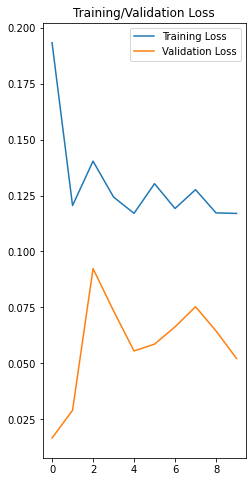

Epoch 1/10
102/102 [==============================] - 1s 10ms/step - loss: 0.1033 - mae: 0.0959 - rmse: 0.1032 - val_loss: 0.0298 - val_mae: 0.0259 - val_rmse: 0.0294
Epoch 2/10
102/102 [==============================] - 1s 10ms/step - loss: 0.1311 - mae: 0.1243 - rmse: 0.1306 - val_loss: 0.0422 - val_mae: 0.0399 - val_rmse: 0.0428
Epoch 3/10
102/102 [==============================] - 1s 10ms/step - loss: 0.1066 - mae: 0.1000 - rmse: 0.1061 - val_loss: 0.0434 - val_mae: 0.0409 - val_rmse: 0.0440
Epoch 4/10
102/102 [==============================] - 1s 10ms/step - loss: 0.0981 - mae: 0.0908 - rmse: 0.0976 - val_loss: 0.0486 - val_mae: 0.0450 - val_rmse: 0.0494
Epoch 5/10
102/102 [==============================] - 1s 10ms/step - loss: 0.0908 - mae: 0.0837 - rmse: 0.0904 - val_loss: 0.0475 - val_mae: 0.0452 - val_rmse: 0.0483

Epoch 00005: val_loss improved from 0.05216 to 0.04754, saving model to my_model_5_0.048.h5
Epoch 6/10
102/102 [==============================] - 1s 9ms/step - loss

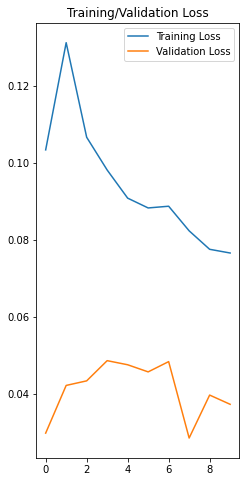

Epoch 1/10
152/152 [==============================] - 3s 8ms/step - loss: 0.0676 - mae: 0.0605 - rmse: 0.0676 - val_loss: 0.0784 - val_mae: 0.0675 - val_rmse: 0.0790
Epoch 2/10
152/152 [==============================] - 1s 8ms/step - loss: 0.0585 - mae: 0.0508 - rmse: 0.0585 - val_loss: 0.0741 - val_mae: 0.0625 - val_rmse: 0.0747
Epoch 3/10
152/152 [==============================] - 1s 8ms/step - loss: 0.0536 - mae: 0.0464 - rmse: 0.0536 - val_loss: 0.0731 - val_mae: 0.0616 - val_rmse: 0.0740
Epoch 4/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0601 - mae: 0.0528 - rmse: 0.0601 - val_loss: 0.0728 - val_mae: 0.0608 - val_rmse: 0.0737
Epoch 5/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0538 - mae: 0.0463 - rmse: 0.0538 - val_loss: 0.0692 - val_mae: 0.0580 - val_rmse: 0.0703

Epoch 00005: val_loss did not improve from 0.03728
Epoch 6/10
152/152 [==============================] - 1s 7ms/step - loss: 0.0580 - mae: 0.0513 - rmse: 0.0580 - val_lo

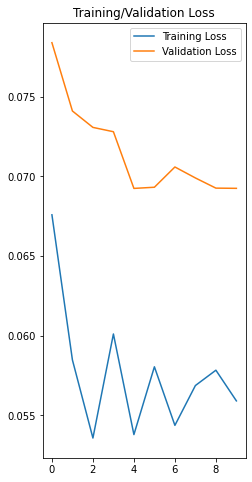

[array([[2514.5286, 2518.6733]], dtype=float32), array([[2531.632 , 2536.3196]], dtype=float32), array([[2549.9133, 2555.0952]], dtype=float32), array([[2566.8835, 2572.0176]], dtype=float32), array([[2582.3567, 2587.3818]], dtype=float32), array([[2597.126 , 2602.1528]], dtype=float32), array([[2612.0186, 2617.17  ]], dtype=float32), array([[2626.978 , 2632.3186]], dtype=float32), array([[2640.9863, 2646.3662]], dtype=float32), array([[2654.3855, 2659.7744]], dtype=float32), array([[2667.0605, 2672.4285]], dtype=float32), array([[2679.026 , 2684.3594]], dtype=float32), array([[2690.3013, 2695.5952]], dtype=float32), array([[2700.8848, 2706.135 ]], dtype=float32), array([[2710.7559, 2715.9553]], dtype=float32)]
[2514.5286, 2531.632, 2549.9133, 2566.8835, 2582.3567, 2597.126, 2612.0186, 2626.978, 2640.9863, 2654.3855, 2667.0605, 2679.026, 2690.3013, 2700.8848, 2710.7559]


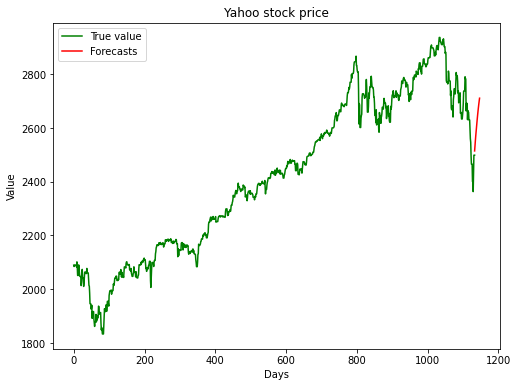

Epoch 1/50
51/51 [==============================] - 5s 27ms/step - loss: 0.3351 - mae: 0.3234 - rmse: 0.3351 - val_loss: 0.0105 - val_mae: 0.0088 - val_rmse: 0.0102
Epoch 2/50
51/51 [==============================] - 0s 10ms/step - loss: 0.1507 - mae: 0.1360 - rmse: 0.1507 - val_loss: 0.0283 - val_mae: 0.0226 - val_rmse: 0.0287
Epoch 3/50
51/51 [==============================] - 1s 10ms/step - loss: 0.1592 - mae: 0.1456 - rmse: 0.1592 - val_loss: 0.0934 - val_mae: 0.0927 - val_rmse: 0.0939
Epoch 4/50
51/51 [==============================] - 1s 10ms/step - loss: 0.1299 - mae: 0.1167 - rmse: 0.1299 - val_loss: 0.0816 - val_mae: 0.0803 - val_rmse: 0.0820
Epoch 5/50
51/51 [==============================] - 0s 10ms/step - loss: 0.1382 - mae: 0.1256 - rmse: 0.1381 - val_loss: 0.0530 - val_mae: 0.0514 - val_rmse: 0.0534

Epoch 00005: val_loss improved from inf to 0.05298, saving model to my_model_5_0.053.h5
Epoch 6/50
51/51 [==============================] - 1s 11ms/step - loss: 0.1664 - mae:

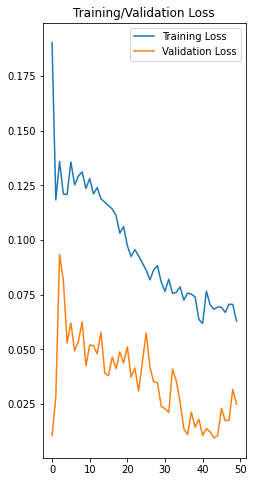

Epoch 1/50
102/102 [==============================] - 1s 10ms/step - loss: 0.0470 - mae: 0.0398 - rmse: 0.0469 - val_loss: 0.0632 - val_mae: 0.0594 - val_rmse: 0.0662
Epoch 2/50
102/102 [==============================] - 1s 9ms/step - loss: 0.0531 - mae: 0.0461 - rmse: 0.0529 - val_loss: 0.0266 - val_mae: 0.0226 - val_rmse: 0.0282
Epoch 3/50
102/102 [==============================] - 1s 10ms/step - loss: 0.0620 - mae: 0.0560 - rmse: 0.0617 - val_loss: 0.0209 - val_mae: 0.0168 - val_rmse: 0.0212
Epoch 4/50
102/102 [==============================] - 1s 10ms/step - loss: 0.0586 - mae: 0.0525 - rmse: 0.0584 - val_loss: 0.0324 - val_mae: 0.0278 - val_rmse: 0.0339
Epoch 5/50
102/102 [==============================] - 1s 10ms/step - loss: 0.0496 - mae: 0.0431 - rmse: 0.0495 - val_loss: 0.0305 - val_mae: 0.0267 - val_rmse: 0.0322

Epoch 00005: val_loss did not improve from 0.01061
Epoch 6/50
102/102 [==============================] - 1s 10ms/step - loss: 0.0535 - mae: 0.0470 - rmse: 0.0533 - v

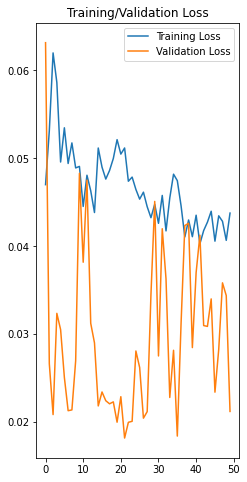

Epoch 1/50
152/152 [==============================] - 3s 8ms/step - loss: 0.0459 - mae: 0.0391 - rmse: 0.0459 - val_loss: 0.0612 - val_mae: 0.0504 - val_rmse: 0.0620
Epoch 2/50
152/152 [==============================] - 1s 8ms/step - loss: 0.0475 - mae: 0.0408 - rmse: 0.0475 - val_loss: 0.0683 - val_mae: 0.0573 - val_rmse: 0.0693
Epoch 3/50
152/152 [==============================] - 1s 8ms/step - loss: 0.0422 - mae: 0.0357 - rmse: 0.0422 - val_loss: 0.0602 - val_mae: 0.0492 - val_rmse: 0.0610
Epoch 4/50
152/152 [==============================] - 1s 8ms/step - loss: 0.0461 - mae: 0.0389 - rmse: 0.0461 - val_loss: 0.0597 - val_mae: 0.0487 - val_rmse: 0.0605
Epoch 5/50
152/152 [==============================] - 1s 8ms/step - loss: 0.0443 - mae: 0.0381 - rmse: 0.0443 - val_loss: 0.0739 - val_mae: 0.0628 - val_rmse: 0.0749

Epoch 00005: val_loss did not improve from 0.01061
Epoch 6/50
152/152 [==============================] - 1s 8ms/step - loss: 0.0399 - mae: 0.0336 - rmse: 0.0399 - val_lo

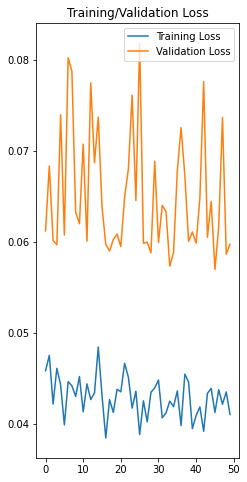

[array([[2501.3977, 2506.8398]], dtype=float32), array([[2521.179, 2526.75 ]], dtype=float32), array([[2540.7014, 2546.354 ]], dtype=float32), array([[2559.1514, 2564.8691]], dtype=float32), array([[2576.8508, 2582.6235]], dtype=float32), array([[2594.2742, 2600.0793]], dtype=float32), array([[2611.784 , 2617.6077]], dtype=float32), array([[2629.2068, 2635.051 ]], dtype=float32), array([[2646.0945, 2651.9634]], dtype=float32), array([[2662.1003, 2667.9924]], dtype=float32), array([[2677.0547, 2682.966 ]], dtype=float32), array([[2690.8906, 2696.817 ]], dtype=float32), array([[2703.5757, 2709.5137]], dtype=float32), array([[2715.093 , 2721.0405]], dtype=float32), array([[2725.4458, 2731.401 ]], dtype=float32)]
[2501.3977, 2521.179, 2540.7014, 2559.1514, 2576.8508, 2594.2742, 2611.784, 2629.2068, 2646.0945, 2662.1003, 2677.0547, 2690.8906, 2703.5757, 2715.093, 2725.4458]


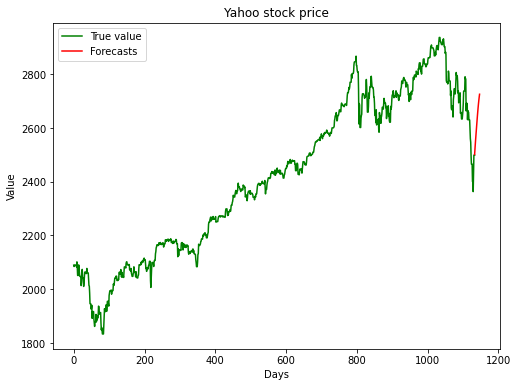

Epoch 1/100
51/51 [==============================] - 5s 29ms/step - loss: 0.3425 - mae: 0.3323 - rmse: 0.3425 - val_loss: 0.0481 - val_mae: 0.0380 - val_rmse: 0.0486
Epoch 2/100
51/51 [==============================] - 1s 11ms/step - loss: 0.1358 - mae: 0.1192 - rmse: 0.1358 - val_loss: 0.0207 - val_mae: 0.0165 - val_rmse: 0.0211
Epoch 3/100
51/51 [==============================] - 1s 10ms/step - loss: 0.1711 - mae: 0.1589 - rmse: 0.1711 - val_loss: 0.0818 - val_mae: 0.0802 - val_rmse: 0.0822
Epoch 4/100
51/51 [==============================] - 1s 12ms/step - loss: 0.1299 - mae: 0.1155 - rmse: 0.1299 - val_loss: 0.0876 - val_mae: 0.0870 - val_rmse: 0.0880
Epoch 5/100
51/51 [==============================] - 1s 10ms/step - loss: 0.1313 - mae: 0.1194 - rmse: 0.1313 - val_loss: 0.0677 - val_mae: 0.0666 - val_rmse: 0.0681

Epoch 00005: val_loss improved from inf to 0.06771, saving model to my_model_5_0.068.h5
Epoch 6/100
51/51 [==============================] - 1s 12ms/step - loss: 0.1479 

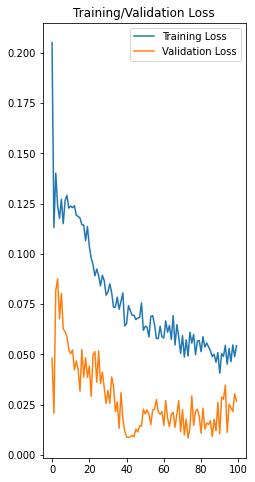

Epoch 1/100
102/102 [==============================] - 1s 13ms/step - loss: 0.0413 - mae: 0.0352 - rmse: 0.0411 - val_loss: 0.0763 - val_mae: 0.0728 - val_rmse: 0.0798
Epoch 2/100
102/102 [==============================] - 1s 11ms/step - loss: 0.0482 - mae: 0.0423 - rmse: 0.0480 - val_loss: 0.0418 - val_mae: 0.0369 - val_rmse: 0.0438
Epoch 3/100
102/102 [==============================] - 1s 11ms/step - loss: 0.0482 - mae: 0.0423 - rmse: 0.0482 - val_loss: 0.0466 - val_mae: 0.0423 - val_rmse: 0.0489
Epoch 4/100
102/102 [==============================] - 1s 12ms/step - loss: 0.0431 - mae: 0.0369 - rmse: 0.0430 - val_loss: 0.0576 - val_mae: 0.0537 - val_rmse: 0.0606
Epoch 5/100
102/102 [==============================] - 1s 12ms/step - loss: 0.0411 - mae: 0.0349 - rmse: 0.0409 - val_loss: 0.0598 - val_mae: 0.0554 - val_rmse: 0.0627

Epoch 00005: val_loss did not improve from 0.00903
Epoch 6/100
102/102 [==============================] - 1s 12ms/step - loss: 0.0389 - mae: 0.0330 - rmse: 0.0

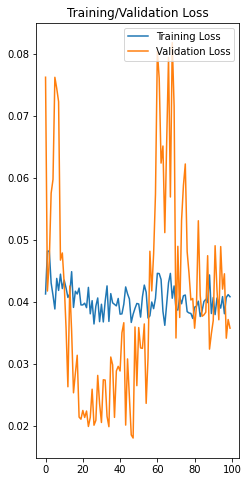

Epoch 1/100
152/152 [==============================] - 3s 8ms/step - loss: 0.0486 - mae: 0.0417 - rmse: 0.0486 - val_loss: 0.0816 - val_mae: 0.0707 - val_rmse: 0.0825
Epoch 2/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0522 - mae: 0.0453 - rmse: 0.0522 - val_loss: 0.0606 - val_mae: 0.0498 - val_rmse: 0.0613
Epoch 3/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0471 - mae: 0.0402 - rmse: 0.0471 - val_loss: 0.0783 - val_mae: 0.0691 - val_rmse: 0.0784
Epoch 4/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0445 - mae: 0.0376 - rmse: 0.0445 - val_loss: 0.0610 - val_mae: 0.0492 - val_rmse: 0.0618
Epoch 5/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0449 - mae: 0.0380 - rmse: 0.0449 - val_loss: 0.1051 - val_mae: 0.0933 - val_rmse: 0.1059

Epoch 00005: val_loss did not improve from 0.00903
Epoch 6/100
152/152 [==============================] - 1s 8ms/step - loss: 0.0410 - mae: 0.0340 - rmse: 0.0410 - 

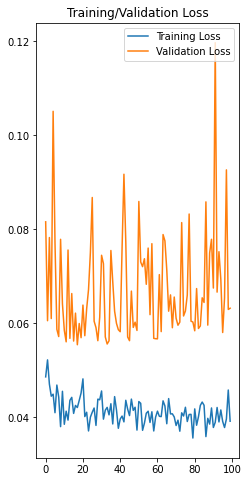

[array([[2488.4143, 2499.9912]], dtype=float32), array([[2500.005 , 2511.6167]], dtype=float32), array([[2512.4175, 2524.1716]], dtype=float32), array([[2524.3035, 2536.2573]], dtype=float32), array([[2535.627, 2547.706]], dtype=float32), array([[2546.8154, 2558.9014]], dtype=float32), array([[2558.1938, 2570.194 ]], dtype=float32), array([[2569.738 , 2581.6182]], dtype=float32), array([[2581.3542, 2593.1052]], dtype=float32), array([[2592.887 , 2604.5017]], dtype=float32), array([[2604.224 , 2615.6833]], dtype=float32), array([[2615.2708, 2626.5466]], dtype=float32), array([[2625.9282, 2636.9922]], dtype=float32), array([[2636.091 , 2646.9158]], dtype=float32), array([[2645.6555, 2656.217 ]], dtype=float32)]
[2488.4143, 2500.005, 2512.4175, 2524.3035, 2535.627, 2546.8154, 2558.1938, 2569.738, 2581.3542, 2592.887, 2604.224, 2615.2708, 2625.9282, 2636.091, 2645.6555]


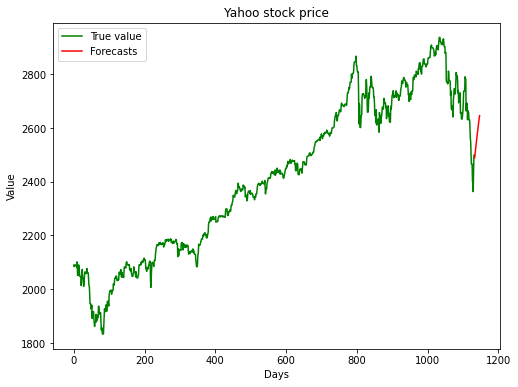

Epoch 1/60
51/51 [==============================] - 5s 28ms/step - loss: 0.2996 - mae: 0.2875 - rmse: 0.2995 - val_loss: 0.0340 - val_mae: 0.0336 - val_rmse: 0.0335
Epoch 2/60
51/51 [==============================] - 1s 12ms/step - loss: 0.1565 - mae: 0.1441 - rmse: 0.1565 - val_loss: 0.0192 - val_mae: 0.0168 - val_rmse: 0.0191
Epoch 3/60
51/51 [==============================] - 1s 12ms/step - loss: 0.1842 - mae: 0.1708 - rmse: 0.1842 - val_loss: 0.0754 - val_mae: 0.0748 - val_rmse: 0.0759
Epoch 4/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1352 - mae: 0.1204 - rmse: 0.1352 - val_loss: 0.0827 - val_mae: 0.0818 - val_rmse: 0.0832
Epoch 5/60
51/51 [==============================] - 1s 11ms/step - loss: 0.1421 - mae: 0.1287 - rmse: 0.1421 - val_loss: 0.0872 - val_mae: 0.0865 - val_rmse: 0.0876

Epoch 00005: val_loss improved from inf to 0.08715, saving model to my_model_5_0.087.h5
Epoch 6/60
51/51 [==============================] - 1s 10ms/step - loss: 0.1385 - mae:

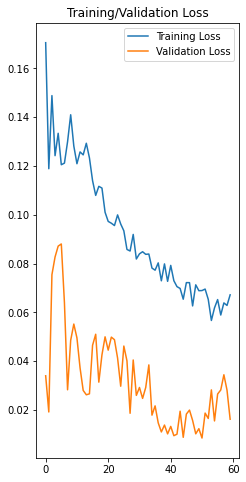

Epoch 1/60
102/102 [==============================] - 1s 11ms/step - loss: 0.0476 - mae: 0.0409 - rmse: 0.0475 - val_loss: 0.0309 - val_mae: 0.0260 - val_rmse: 0.0308
Epoch 2/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0501 - mae: 0.0434 - rmse: 0.0499 - val_loss: 0.0276 - val_mae: 0.0227 - val_rmse: 0.0274
Epoch 3/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0591 - mae: 0.0529 - rmse: 0.0587 - val_loss: 0.0324 - val_mae: 0.0260 - val_rmse: 0.0322
Epoch 4/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0598 - mae: 0.0531 - rmse: 0.0594 - val_loss: 0.0290 - val_mae: 0.0239 - val_rmse: 0.0286
Epoch 5/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0548 - mae: 0.0483 - rmse: 0.0544 - val_loss: 0.0205 - val_mae: 0.0165 - val_rmse: 0.0206

Epoch 00005: val_loss did not improve from 0.00881
Epoch 6/60
102/102 [==============================] - 1s 10ms/step - loss: 0.0480 - mae: 0.0418 - rmse: 0.0477 - 

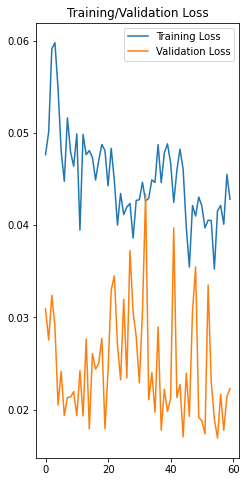

Epoch 1/60
152/152 [==============================] - 2s 11ms/step - loss: 0.0467 - mae: 0.0400 - rmse: 0.0467 - val_loss: 0.1206 - val_mae: 0.1133 - val_rmse: 0.1203
Epoch 2/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0474 - mae: 0.0407 - rmse: 0.0474 - val_loss: 0.0613 - val_mae: 0.0508 - val_rmse: 0.0619
Epoch 3/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0404 - mae: 0.0341 - rmse: 0.0404 - val_loss: 0.0628 - val_mae: 0.0528 - val_rmse: 0.0633
Epoch 4/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0427 - mae: 0.0362 - rmse: 0.0427 - val_loss: 0.0608 - val_mae: 0.0503 - val_rmse: 0.0614
Epoch 5/60
152/152 [==============================] - 2s 11ms/step - loss: 0.0389 - mae: 0.0325 - rmse: 0.0389 - val_loss: 0.0980 - val_mae: 0.0901 - val_rmse: 0.0979

Epoch 00005: val_loss did not improve from 0.00881
Epoch 6/60
152/152 [==============================] - 2s 10ms/step - loss: 0.0437 - mae: 0.0370 - rmse: 0.0437 - 

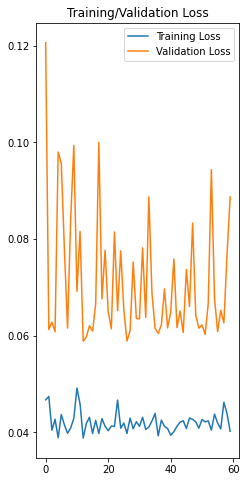

[array([[2485.0833, 2490.5315]], dtype=float32), array([[2489.0833, 2494.4875]], dtype=float32), array([[2494.4792, 2499.8662]], dtype=float32), array([[2500.7847, 2506.1821]], dtype=float32), array([[2506.853 , 2512.2756]], dtype=float32), array([[2512.3008, 2517.7498]], dtype=float32), array([[2517.2942, 2522.7646]], dtype=float32), array([[2522.1345, 2527.6228]], dtype=float32), array([[2526.965, 2532.47 ]], dtype=float32), array([[2531.799 , 2537.3208]], dtype=float32), array([[2536.5803, 2542.1191]], dtype=float32), array([[2541.2532, 2546.8098]], dtype=float32), array([[2545.7786, 2551.3525]], dtype=float32), array([[2550.141 , 2555.7322]], dtype=float32), array([[2554.3394, 2559.947 ]], dtype=float32)]
[2485.0833, 2489.0833, 2494.4792, 2500.7847, 2506.853, 2512.3008, 2517.2942, 2522.1345, 2526.965, 2531.799, 2536.5803, 2541.2532, 2545.7786, 2550.141, 2554.3394]


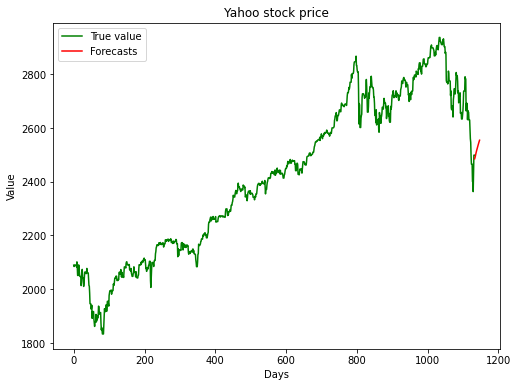

Epoch 1/90
51/51 [==============================] - 5s 36ms/step - loss: 0.2965 - mae: 0.2844 - rmse: 0.2964 - val_loss: 0.0198 - val_mae: 0.0170 - val_rmse: 0.0193
Epoch 2/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1446 - mae: 0.1285 - rmse: 0.1446 - val_loss: 0.0122 - val_mae: 0.0101 - val_rmse: 0.0120
Epoch 3/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1811 - mae: 0.1687 - rmse: 0.1811 - val_loss: 0.0671 - val_mae: 0.0643 - val_rmse: 0.0676
Epoch 4/90
51/51 [==============================] - 1s 12ms/step - loss: 0.1401 - mae: 0.1267 - rmse: 0.1401 - val_loss: 0.0685 - val_mae: 0.0673 - val_rmse: 0.0690
Epoch 5/90
51/51 [==============================] - 1s 11ms/step - loss: 0.1436 - mae: 0.1300 - rmse: 0.1436 - val_loss: 0.0786 - val_mae: 0.0774 - val_rmse: 0.0791

Epoch 00005: val_loss improved from inf to 0.07863, saving model to my_model_5_0.079.h5
Epoch 6/90
51/51 [==============================] - 1s 12ms/step - loss: 0.1405 - mae:

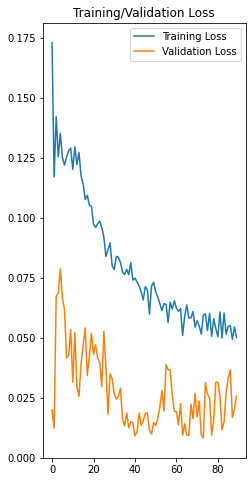

Epoch 1/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0424 - mae: 0.0363 - rmse: 0.0424 - val_loss: 0.0564 - val_mae: 0.0518 - val_rmse: 0.0600
Epoch 2/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0437 - mae: 0.0374 - rmse: 0.0436 - val_loss: 0.0515 - val_mae: 0.0465 - val_rmse: 0.0542
Epoch 3/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0513 - mae: 0.0451 - rmse: 0.0510 - val_loss: 0.0373 - val_mae: 0.0326 - val_rmse: 0.0398
Epoch 4/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0521 - mae: 0.0464 - rmse: 0.0519 - val_loss: 0.0395 - val_mae: 0.0338 - val_rmse: 0.0419
Epoch 5/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0433 - mae: 0.0372 - rmse: 0.0431 - val_loss: 0.0673 - val_mae: 0.0628 - val_rmse: 0.0706

Epoch 00005: val_loss did not improve from 0.01406
Epoch 6/90
102/102 [==============================] - 1s 11ms/step - loss: 0.0421 - mae: 0.0361 - rmse: 0.0419 - 

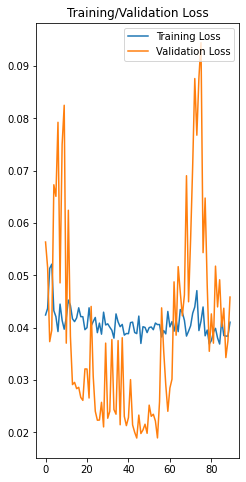

Epoch 1/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0426 - mae: 0.0358 - rmse: 0.0427 - val_loss: 0.0660 - val_mae: 0.0556 - val_rmse: 0.0665
Epoch 2/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0479 - mae: 0.0409 - rmse: 0.0479 - val_loss: 0.1003 - val_mae: 0.0927 - val_rmse: 0.1001
Epoch 3/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0401 - mae: 0.0335 - rmse: 0.0401 - val_loss: 0.0782 - val_mae: 0.0695 - val_rmse: 0.0784
Epoch 4/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0412 - mae: 0.0349 - rmse: 0.0412 - val_loss: 0.0981 - val_mae: 0.0902 - val_rmse: 0.0980
Epoch 5/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0422 - mae: 0.0357 - rmse: 0.0422 - val_loss: 0.0781 - val_mae: 0.0695 - val_rmse: 0.0783

Epoch 00005: val_loss did not improve from 0.01406
Epoch 6/90
152/152 [==============================] - 2s 11ms/step - loss: 0.0437 - mae: 0.0372 - rmse: 0.0437 - 

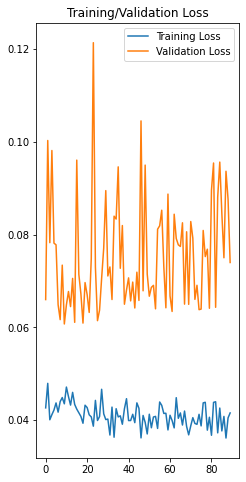

[array([[2491.2817, 2504.4275]], dtype=float32), array([[2504.2432, 2517.728 ]], dtype=float32), array([[2517.8323, 2531.1184]], dtype=float32), array([[2530.582 , 2543.4136]], dtype=float32), array([[2542.339 , 2554.8687]], dtype=float32), array([[2553.35  , 2565.6655]], dtype=float32), array([[2564.008 , 2576.0457]], dtype=float32), array([[2574.6582, 2586.284 ]], dtype=float32), array([[2585.3054, 2596.4512]], dtype=float32), array([[2595.7417, 2606.4314]], dtype=float32), array([[2605.778 , 2616.0408]], dtype=float32), array([[2615.285 , 2625.1416]], dtype=float32), array([[2624.1987, 2633.6633]], dtype=float32), array([[2632.4883, 2641.576 ]], dtype=float32), array([[2640.1318, 2648.8613]], dtype=float32)]
[2491.2817, 2504.2432, 2517.8323, 2530.582, 2542.339, 2553.35, 2564.008, 2574.6582, 2585.3054, 2595.7417, 2605.778, 2615.285, 2624.1987, 2632.4883, 2640.1318]


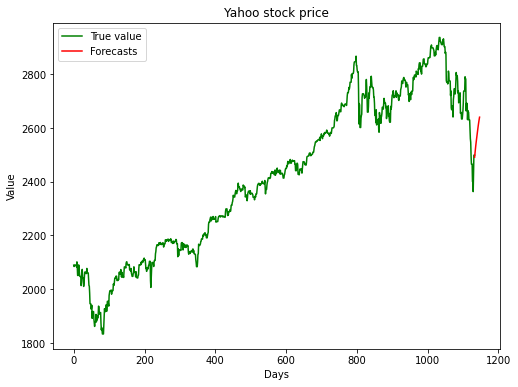

Epoch 1/120
51/51 [==============================] - 5s 27ms/step - loss: 0.2523 - mae: 0.2396 - rmse: 0.2522 - val_loss: 0.0155 - val_mae: 0.0134 - val_rmse: 0.0151
Epoch 2/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1172 - mae: 0.1031 - rmse: 0.1172 - val_loss: 0.0273 - val_mae: 0.0268 - val_rmse: 0.0268
Epoch 3/120
51/51 [==============================] - 1s 11ms/step - loss: 0.1808 - mae: 0.1698 - rmse: 0.1808 - val_loss: 0.0663 - val_mae: 0.0655 - val_rmse: 0.0668
Epoch 4/120
51/51 [==============================] - 1s 12ms/step - loss: 0.1448 - mae: 0.1318 - rmse: 0.1448 - val_loss: 0.0723 - val_mae: 0.0705 - val_rmse: 0.0728
Epoch 5/120
51/51 [==============================] - 1s 12ms/step - loss: 0.1425 - mae: 0.1292 - rmse: 0.1425 - val_loss: 0.0854 - val_mae: 0.0848 - val_rmse: 0.0859

Epoch 00005: val_loss improved from inf to 0.08539, saving model to my_model_5_0.085.h5
Epoch 6/120
51/51 [==============================] - 1s 13ms/step - loss: 0.1332 

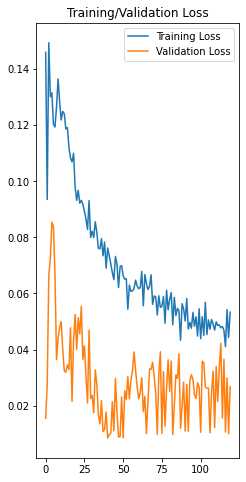

Epoch 1/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0425 - mae: 0.0367 - rmse: 0.0426 - val_loss: 0.0446 - val_mae: 0.0400 - val_rmse: 0.0469
Epoch 2/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0476 - mae: 0.0418 - rmse: 0.0473 - val_loss: 0.0681 - val_mae: 0.0609 - val_rmse: 0.0705
Epoch 3/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0452 - mae: 0.0390 - rmse: 0.0452 - val_loss: 0.0940 - val_mae: 0.0907 - val_rmse: 0.0976
Epoch 4/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0421 - mae: 0.0363 - rmse: 0.0420 - val_loss: 0.0568 - val_mae: 0.0530 - val_rmse: 0.0596
Epoch 5/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0423 - mae: 0.0363 - rmse: 0.0420 - val_loss: 0.0380 - val_mae: 0.0338 - val_rmse: 0.0403

Epoch 00005: val_loss did not improve from 0.01099
Epoch 6/120
102/102 [==============================] - 1s 11ms/step - loss: 0.0455 - mae: 0.0396 - rmse: 0.0

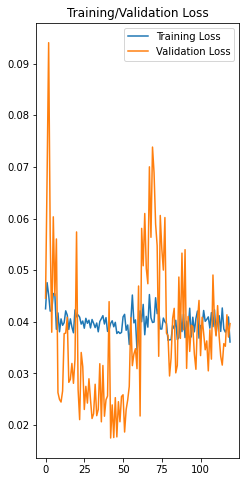

Epoch 1/120
152/152 [==============================] - 2s 12ms/step - loss: 0.0469 - mae: 0.0401 - rmse: 0.0470 - val_loss: 0.0651 - val_mae: 0.0544 - val_rmse: 0.0660
Epoch 2/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0430 - mae: 0.0361 - rmse: 0.0430 - val_loss: 0.0769 - val_mae: 0.0685 - val_rmse: 0.0771
Epoch 3/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0479 - mae: 0.0410 - rmse: 0.0480 - val_loss: 0.0674 - val_mae: 0.0566 - val_rmse: 0.0682
Epoch 4/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0433 - mae: 0.0369 - rmse: 0.0433 - val_loss: 0.1017 - val_mae: 0.0945 - val_rmse: 0.1015
Epoch 5/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0416 - mae: 0.0348 - rmse: 0.0416 - val_loss: 0.0882 - val_mae: 0.0802 - val_rmse: 0.0882

Epoch 00005: val_loss did not improve from 0.01099
Epoch 6/120
152/152 [==============================] - 2s 11ms/step - loss: 0.0427 - mae: 0.0365 - rmse: 0.0

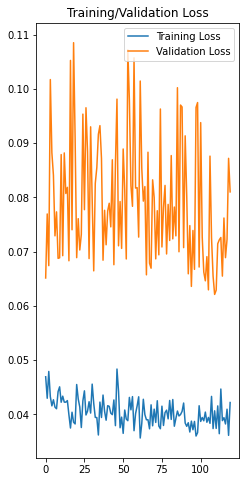

[array([[2473.5522, 2485.733 ]], dtype=float32), array([[2473.4058, 2483.6855]], dtype=float32), array([[2475.2568, 2484.697 ]], dtype=float32), array([[2478.2893, 2487.7031]], dtype=float32), array([[2480.987 , 2490.5022]], dtype=float32), array([[2482.8755, 2492.5774]], dtype=float32), array([[2484.2637, 2494.119 ]], dtype=float32), array([[2485.4922, 2495.3955]], dtype=float32), array([[2486.7803, 2496.6624]], dtype=float32), array([[2488.1858, 2498.0046]], dtype=float32), array([[2489.6267, 2499.406 ]], dtype=float32), array([[2491.0513, 2500.8096]], dtype=float32), array([[2492.4353, 2502.18  ]], dtype=float32), array([[2493.7812, 2503.5115]], dtype=float32), array([[2495.1018, 2504.8142]], dtype=float32)]
[2473.5522, 2473.4058, 2475.2568, 2478.2893, 2480.987, 2482.8755, 2484.2637, 2485.4922, 2486.7803, 2488.1858, 2489.6267, 2491.0513, 2492.4353, 2493.7812, 2495.1018]


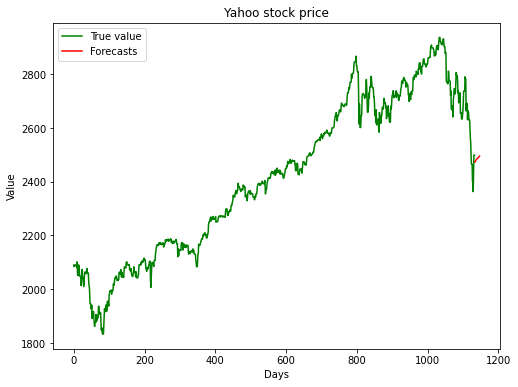

Epoch 1/50
32/32 [==============================] - 5s 42ms/step - loss: 0.4102 - mae: 0.3983 - rmse: 0.4101 - val_loss: 0.0249 - val_mae: 0.0212 - val_rmse: 0.0272
Epoch 2/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1367 - mae: 0.1174 - rmse: 0.1367 - val_loss: 0.0363 - val_mae: 0.0333 - val_rmse: 0.0367
Epoch 3/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1468 - mae: 0.1294 - rmse: 0.1468 - val_loss: 0.0309 - val_mae: 0.0262 - val_rmse: 0.0331
Epoch 4/50
32/32 [==============================] - 0s 14ms/step - loss: 0.1497 - mae: 0.1319 - rmse: 0.1497 - val_loss: 0.0187 - val_mae: 0.0143 - val_rmse: 0.0219
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1585 - mae: 0.1429 - rmse: 0.1584 - val_loss: 0.0207 - val_mae: 0.0141 - val_rmse: 0.0250

Epoch 00005: val_loss improved from inf to 0.02068, saving model to my_model_5_0.021.h5
Epoch 6/50
32/32 [==============================] - 0s 15ms/step - loss: 0.1816 - mae:

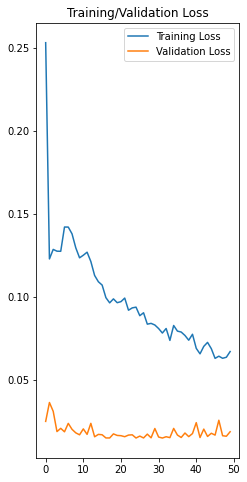

Epoch 1/50
64/64 [==============================] - 2s 27ms/step - loss: 0.0496 - mae: 0.0411 - rmse: 0.0495 - val_loss: 0.0249 - val_mae: 0.0205 - val_rmse: 0.0249
Epoch 2/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0516 - mae: 0.0433 - rmse: 0.0515 - val_loss: 0.0267 - val_mae: 0.0226 - val_rmse: 0.0267
Epoch 3/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0526 - mae: 0.0439 - rmse: 0.0524 - val_loss: 0.0376 - val_mae: 0.0343 - val_rmse: 0.0376
Epoch 4/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0492 - mae: 0.0408 - rmse: 0.0489 - val_loss: 0.0315 - val_mae: 0.0280 - val_rmse: 0.0315
Epoch 5/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0534 - mae: 0.0453 - rmse: 0.0530 - val_loss: 0.0295 - val_mae: 0.0259 - val_rmse: 0.0295

Epoch 00005: val_loss did not improve from 0.01486
Epoch 6/50
64/64 [==============================] - 1s 14ms/step - loss: 0.0491 - mae: 0.0408 - rmse: 0.0488 - val_loss: 0.

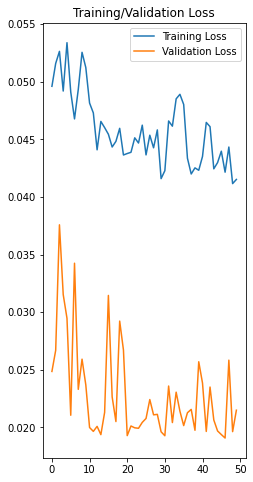

Epoch 1/50
95/95 [==============================] - 1s 14ms/step - loss: 0.0429 - mae: 0.0358 - rmse: 0.0430 - val_loss: 0.0780 - val_mae: 0.0645 - val_rmse: 0.0803
Epoch 2/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0537 - mae: 0.0463 - rmse: 0.0537 - val_loss: 0.0755 - val_mae: 0.0620 - val_rmse: 0.0791
Epoch 3/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0562 - mae: 0.0490 - rmse: 0.0562 - val_loss: 0.0820 - val_mae: 0.0688 - val_rmse: 0.0838
Epoch 4/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0397 - mae: 0.0325 - rmse: 0.0397 - val_loss: 0.0808 - val_mae: 0.0649 - val_rmse: 0.0852
Epoch 5/50
95/95 [==============================] - 1s 13ms/step - loss: 0.0420 - mae: 0.0347 - rmse: 0.0420 - val_loss: 0.0898 - val_mae: 0.0774 - val_rmse: 0.0908

Epoch 00005: val_loss did not improve from 0.01486
Epoch 6/50
95/95 [==============================] - 1s 14ms/step - loss: 0.0435 - mae: 0.0363 - rmse: 0.0436 - val_loss: 0.

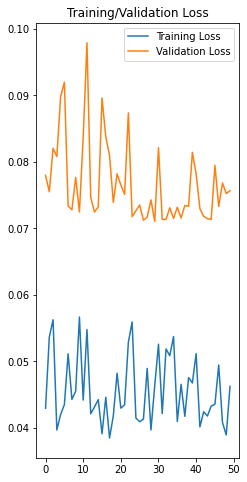

[array([[2454.6726, 2461.3774]], dtype=float32), array([[2439.8494, 2445.9578]], dtype=float32), array([[2430.551 , 2436.3967]], dtype=float32), array([[2422.3125, 2428.002 ]], dtype=float32), array([[2413.5122, 2419.0752]], dtype=float32), array([[2403.663 , 2409.1213]], dtype=float32), array([[2391.983, 2397.333]], dtype=float32), array([[2378.9504, 2384.203 ]], dtype=float32), array([[2365.0566, 2370.2136]], dtype=float32), array([[2350.3257, 2355.3774]], dtype=float32), array([[2334.8425, 2339.778 ]], dtype=float32), array([[2318.5513, 2323.3564]], dtype=float32), array([[2301.44  , 2306.1082]], dtype=float32), array([[2283.542 , 2288.0698]], dtype=float32), array([[2264.9407, 2269.3235]], dtype=float32)]
[2454.6726, 2439.8494, 2430.551, 2422.3125, 2413.5122, 2403.663, 2391.983, 2378.9504, 2365.0566, 2350.3257, 2334.8425, 2318.5513, 2301.44, 2283.542, 2264.9407]


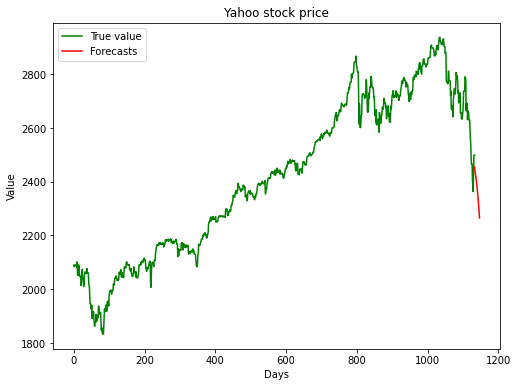

Epoch 1/90
32/32 [==============================] - 5s 43ms/step - loss: 0.3850 - mae: 0.3700 - rmse: 0.3850 - val_loss: 0.0556 - val_mae: 0.0425 - val_rmse: 0.0545
Epoch 2/90
32/32 [==============================] - 0s 15ms/step - loss: 0.1374 - mae: 0.1180 - rmse: 0.1374 - val_loss: 0.0336 - val_mae: 0.0304 - val_rmse: 0.0343
Epoch 3/90
32/32 [==============================] - 0s 15ms/step - loss: 0.1372 - mae: 0.1204 - rmse: 0.1371 - val_loss: 0.0254 - val_mae: 0.0203 - val_rmse: 0.0270
Epoch 4/90
32/32 [==============================] - 0s 15ms/step - loss: 0.1488 - mae: 0.1339 - rmse: 0.1487 - val_loss: 0.0175 - val_mae: 0.0123 - val_rmse: 0.0207
Epoch 5/90
32/32 [==============================] - 1s 16ms/step - loss: 0.1546 - mae: 0.1409 - rmse: 0.1546 - val_loss: 0.0196 - val_mae: 0.0145 - val_rmse: 0.0225

Epoch 00005: val_loss improved from inf to 0.01960, saving model to my_model_5_0.020.h5
Epoch 6/90
32/32 [==============================] - 0s 15ms/step - loss: 0.1755 - mae:

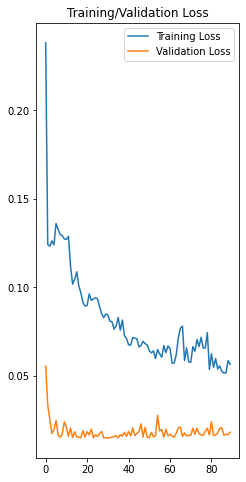

Epoch 1/90
64/64 [==============================] - 2s 28ms/step - loss: 0.0423 - mae: 0.0347 - rmse: 0.0419 - val_loss: 0.0598 - val_mae: 0.0563 - val_rmse: 0.0598
Epoch 2/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0488 - mae: 0.0410 - rmse: 0.0486 - val_loss: 0.0449 - val_mae: 0.0411 - val_rmse: 0.0449
Epoch 3/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0441 - mae: 0.0367 - rmse: 0.0441 - val_loss: 0.0369 - val_mae: 0.0326 - val_rmse: 0.0369
Epoch 4/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0462 - mae: 0.0388 - rmse: 0.0466 - val_loss: 0.0476 - val_mae: 0.0442 - val_rmse: 0.0476
Epoch 5/90
64/64 [==============================] - 1s 14ms/step - loss: 0.0429 - mae: 0.0354 - rmse: 0.0429 - val_loss: 0.0250 - val_mae: 0.0203 - val_rmse: 0.0250

Epoch 00005: val_loss did not improve from 0.01498
Epoch 6/90
64/64 [==============================] - 1s 15ms/step - loss: 0.0407 - mae: 0.0333 - rmse: 0.0406 - val_loss: 0.

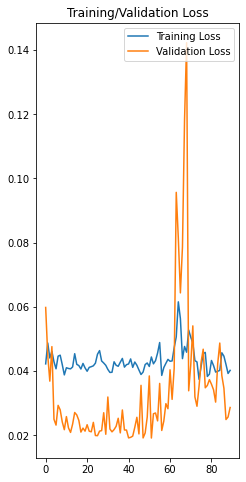

Epoch 1/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0497 - mae: 0.0421 - rmse: 0.0499 - val_loss: 0.0773 - val_mae: 0.0624 - val_rmse: 0.0810
Epoch 2/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0545 - mae: 0.0464 - rmse: 0.0548 - val_loss: 0.1170 - val_mae: 0.1000 - val_rmse: 0.1207
Epoch 3/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0518 - mae: 0.0443 - rmse: 0.0518 - val_loss: 0.1055 - val_mae: 0.0940 - val_rmse: 0.1052
Epoch 4/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0528 - mae: 0.0455 - rmse: 0.0529 - val_loss: 0.0761 - val_mae: 0.0630 - val_rmse: 0.0783
Epoch 5/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0421 - mae: 0.0347 - rmse: 0.0422 - val_loss: 0.0721 - val_mae: 0.0574 - val_rmse: 0.0752

Epoch 00005: val_loss did not improve from 0.01498
Epoch 6/90
95/95 [==============================] - 1s 14ms/step - loss: 0.0449 - mae: 0.0378 - rmse: 0.0449 - val_loss: 0.

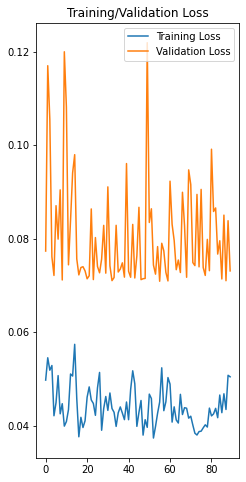

[array([[2486.8467, 2495.1243]], dtype=float32), array([[2493.7075, 2501.8135]], dtype=float32), array([[2501.13  , 2509.1572]], dtype=float32), array([[2508.7595, 2516.7158]], dtype=float32), array([[2516.5981, 2524.4631]], dtype=float32), array([[2524.2827, 2532.0872]], dtype=float32), array([[2531.3625, 2539.1384]], dtype=float32), array([[2537.9514, 2545.7144]], dtype=float32), array([[2544.312 , 2552.0562]], dtype=float32), array([[2550.5837, 2558.2922]], dtype=float32), array([[2556.7725, 2564.438 ]], dtype=float32), array([[2562.8389, 2570.458 ]], dtype=float32), array([[2568.7568, 2576.3306]], dtype=float32), array([[2574.5164, 2582.0454]], dtype=float32), array([[2580.1118, 2587.5967]], dtype=float32)]
[2486.8467, 2493.7075, 2501.13, 2508.7595, 2516.5981, 2524.2827, 2531.3625, 2537.9514, 2544.312, 2550.5837, 2556.7725, 2562.8389, 2568.7568, 2574.5164, 2580.1118]


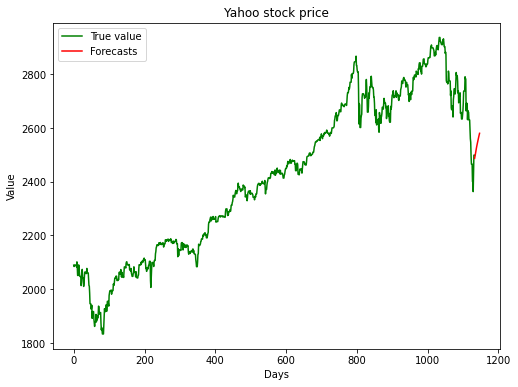

Epoch 1/120
32/32 [==============================] - 5s 42ms/step - loss: 0.3984 - mae: 0.3844 - rmse: 0.3983 - val_loss: 0.0223 - val_mae: 0.0176 - val_rmse: 0.0254
Epoch 2/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1454 - mae: 0.1239 - rmse: 0.1453 - val_loss: 0.0197 - val_mae: 0.0150 - val_rmse: 0.0223
Epoch 3/120
32/32 [==============================] - 1s 16ms/step - loss: 0.1506 - mae: 0.1321 - rmse: 0.1506 - val_loss: 0.0155 - val_mae: 0.0102 - val_rmse: 0.0197
Epoch 4/120
32/32 [==============================] - 0s 14ms/step - loss: 0.1584 - mae: 0.1430 - rmse: 0.1584 - val_loss: 0.0196 - val_mae: 0.0138 - val_rmse: 0.0238
Epoch 5/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1676 - mae: 0.1542 - rmse: 0.1675 - val_loss: 0.0197 - val_mae: 0.0132 - val_rmse: 0.0240

Epoch 00005: val_loss improved from inf to 0.01967, saving model to my_model_5_0.020.h5
Epoch 6/120
32/32 [==============================] - 0s 15ms/step - loss: 0.1918 

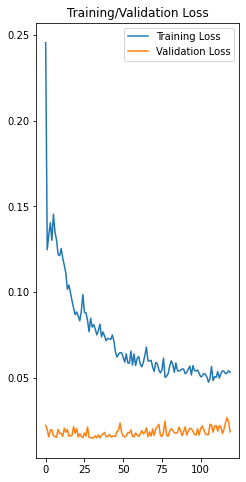

Epoch 1/120
64/64 [==============================] - 2s 28ms/step - loss: 0.0450 - mae: 0.0378 - rmse: 0.0447 - val_loss: 0.0922 - val_mae: 0.0885 - val_rmse: 0.0922
Epoch 2/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0445 - mae: 0.0372 - rmse: 0.0444 - val_loss: 0.0884 - val_mae: 0.0851 - val_rmse: 0.0884
Epoch 3/120
64/64 [==============================] - 1s 15ms/step - loss: 0.0492 - mae: 0.0416 - rmse: 0.0496 - val_loss: 0.0514 - val_mae: 0.0479 - val_rmse: 0.0514
Epoch 4/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0440 - mae: 0.0365 - rmse: 0.0440 - val_loss: 0.0295 - val_mae: 0.0251 - val_rmse: 0.0295
Epoch 5/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0425 - mae: 0.0349 - rmse: 0.0425 - val_loss: 0.0220 - val_mae: 0.0181 - val_rmse: 0.0220

Epoch 00005: val_loss did not improve from 0.01508
Epoch 6/120
64/64 [==============================] - 1s 14ms/step - loss: 0.0430 - mae: 0.0354 - rmse: 0.0430 - val_lo

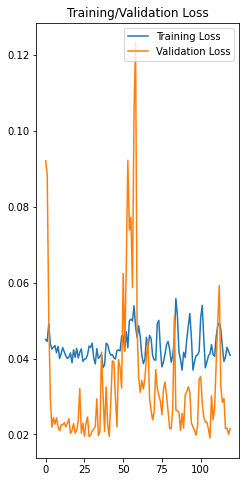

Epoch 1/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0466 - mae: 0.0394 - rmse: 0.0467 - val_loss: 0.1088 - val_mae: 0.0918 - val_rmse: 0.1128
Epoch 2/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0475 - mae: 0.0394 - rmse: 0.0475 - val_loss: 0.0842 - val_mae: 0.0693 - val_rmse: 0.0857
Epoch 3/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0525 - mae: 0.0451 - rmse: 0.0526 - val_loss: 0.0793 - val_mae: 0.0665 - val_rmse: 0.0813
Epoch 4/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0478 - mae: 0.0403 - rmse: 0.0478 - val_loss: 0.0725 - val_mae: 0.0581 - val_rmse: 0.0756
Epoch 5/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0410 - mae: 0.0339 - rmse: 0.0412 - val_loss: 0.0945 - val_mae: 0.0825 - val_rmse: 0.0951

Epoch 00005: val_loss did not improve from 0.01508
Epoch 6/120
95/95 [==============================] - 1s 14ms/step - loss: 0.0426 - mae: 0.0349 - rmse: 0.0427 - val_lo

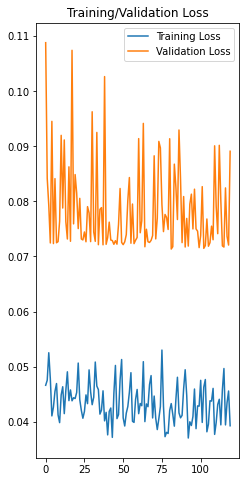

[array([[2467.272 , 2478.6062]], dtype=float32), array([[2462.6008, 2472.155 ]], dtype=float32), array([[2461.0647, 2470.0103]], dtype=float32), array([[2460.1504, 2468.667 ]], dtype=float32), array([[2459.4814, 2467.6902]], dtype=float32), array([[2458.522, 2466.597]], dtype=float32), array([[2457.7068, 2465.7046]], dtype=float32), array([[2456.6282, 2464.7095]], dtype=float32), array([[2455.2932, 2463.489 ]], dtype=float32), array([[2453.9314, 2462.2026]], dtype=float32), array([[2452.6582, 2460.96  ]], dtype=float32), array([[2451.545 , 2459.8423]], dtype=float32), array([[2450.4995, 2458.8005]], dtype=float32), array([[2449.4956, 2457.8044]], dtype=float32), array([[2448.5254, 2456.8445]], dtype=float32)]
[2467.272, 2462.6008, 2461.0647, 2460.1504, 2459.4814, 2458.522, 2457.7068, 2456.6282, 2455.2932, 2453.9314, 2452.6582, 2451.545, 2450.4995, 2449.4956, 2448.5254]


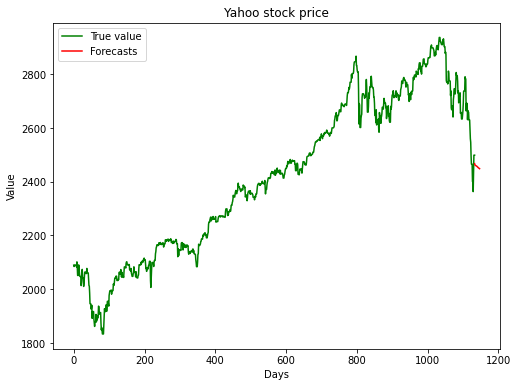

In [17]:
for t in tunning_dict:
  #print(record[r])
  # fitting the model
  timesteps = tunning_dict[t]['timesteps']
  epochs = tunning_dict[t]['epochs']
  batch_size= tunning_dict[t]['batch_size']
  multisteps= tunning_dict[t]['multisteps']
  cv_splits = tunning_dict[t]['cv_splits']
  #print(timesteps,epochs,batch_size,cv_splits)

  X, y = to_supervised(df, timesteps)

  model = build_model(timesteps, n_variate)
  model, history = compile_and_fit(model, epochs, batch_size)
  #print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
  forecasts = forecast(model, df, timesteps, multisteps, scaler)

  print(forecasts)

  prev = []

  #plot do valor previsto da ação de Open
  for f in forecasts:
    prev.append(f[0][0])

  print(prev)
  plot_forecast(df_raw, prev)

  #Scorer
  

  record[t] = history

In [18]:
id_tunning = 1
id_split =1

final_dict = {}

for r in record:
#print(tunning_dict[1]['epochs'])
  loss = []
  mae =[]
  rmse = []
  val_loss = []
  val_mae = []
  val_rmse = []

  for h in record[r]:
    #print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
    #plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
    #['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
    #print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    loss.append(sum(h.history['loss'])/len(h.history['loss']))
    mae.append(sum(h.history['mae'])/len(h.history['mae']))
    rmse.append(sum(h.history['rmse'])/len(h.history['rmse']))
    val_loss.append(sum(h.history['val_loss'])/len(h.history['val_loss']))
    val_mae.append(sum(h.history['val_mae'])/len(h.history['val_mae']))
    val_rmse.append(sum(h.history['val_rmse'])/len(h.history['val_rmse']))
    id_split+=1
  id_split=1
  
  final_dict[id_tunning]=[sum(loss)/len(loss), sum(mae)/len(mae),sum(rmse)/len(rmse),sum(val_loss)/len(val_loss),sum(val_mae)/len(val_mae), sum(val_rmse)/len(val_rmse)]

  id_tunning=id_tunning+1



In [19]:
for f in final_dict:
  print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
  print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.09422063603997229, 0.08529713141421476, 0.09405006344119708, 0.05701802882055442, 0.05175504687552651, 0.05760532387842735] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.062028030976653104, 0.05456536091864109, 0.061921585251887644, 0.04361455300201972, 0.03835860437713564, 0.044414641000330456] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.05277522960056861, 0.0456616760417819, 0.05272723529487849, 0.04519779992600281, 0.0402513960050419, 0.04557848098377387] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.05998475961387157, 0.05266447972713245, 0.059810529359512865, 0.042629043012857436, 0.037743848303539884, 0.042876465240907345] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.054031216629125446, 0.04686850852298516, 0.053919101672040094, 0.04740973091511815, 0.0427530252

In [20]:
final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.094221,0.085297,0.094050,0.057018,0.051755,0.057605
2,0.062028,0.054565,0.061922,0.043615,0.038359,0.044415
3,0.052775,0.045662,0.052727,0.045198,0.040251,0.045578
4,0.059985,0.052664,0.059811,0.042629,0.037744,0.042876
5,0.054031,0.046869,0.053919,0.047410,0.042753,0.047846
6,0.050787,0.043867,0.050697,0.048390,0.044016,0.048722
7,0.063010,0.054074,0.062796,0.039310,0.031449,0.041518
8,0.056271,0.047795,0.056114,0.044086,0.036365,0.046105
9,0.052991,0.044706,0.052849,0.043122,0.035355,0.045357


In [21]:
final_df.to_csv(r"resultados",index=True)